In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [25]:
import warnings
warnings.filterwarnings('ignore')

In [26]:
df = pd.read_csv('data/heroes.csv')

In [27]:
df.head(3)

,year,month,day,hero_1_team_0,hero_1_team_1,hero_2_team_0,hero_2_team_1,hero_3_team_0,hero_3_team_1,hero_4_team_0,...,hero_137_team_1,hero_138_team_0,hero_138_team_1,hero_139_team_0,hero_139_team_1,hero_140_team_0,hero_140_team_1,result,duration,score
0,2023,6,10,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,1119,34
1,2023,6,10,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,2404,100
2,2023,6,10,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,1294,36


In [28]:
df.isna().sum()

year               0
month              0
day                0
hero_1_team_0      0
hero_1_team_1      0
                  ..
hero_140_team_0    0
hero_140_team_1    0
result             0
duration           0
score              0
Length: 286, dtype: int64

In [29]:
df.shape

(26099, 286)

In [30]:
df = df.drop(columns = ['duration', 'score'])

In [31]:
from sklearn.model_selection import train_test_split

X = df.drop(columns=['result']).values
y = df['result'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, random_state=7)

In [32]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

pipe = Pipeline([
    ('scaler', StandardScaler()), 
    ('logreg', LogisticRegression())  
])

param_grid = {
    'logreg__C': [0.01, 0.1, 1, 10],
    'logreg__penalty': ['l1', 'l2'],
    'logreg__solver': ['lbfgs', 'liblinear'],
    'logreg__max_iter': [100, 250, 500, 700]
    
}

grid_logreg = GridSearchCV(pipe, param_grid, cv=10, scoring='roc_auc', n_jobs=-1)

grid_logreg.fit(X_train, y_train)

print("Best Parameters: ", grid_logreg.best_params_)
print("Best Score: ", grid_logreg.best_score_)


Best Parameters:  {'logreg__C': 10, 'logreg__max_iter': 100, 'logreg__penalty': 'l2', 'logreg__solver': 'lbfgs'}
Best Score:  0.5640694730104338


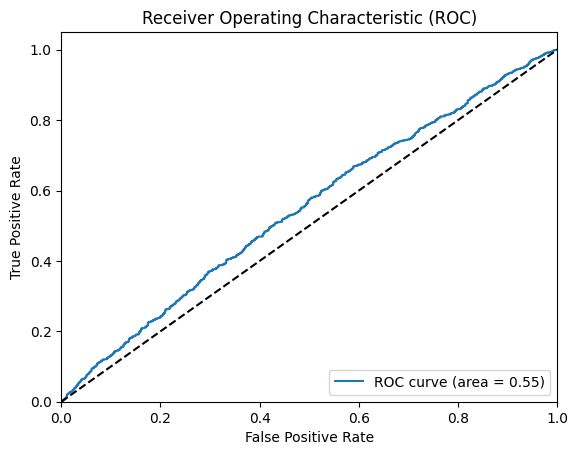

In [33]:
from sklearn.metrics import roc_curve, auc

y_score = grid_logreg.predict_proba(X_test)[:,1]
fpr, tpr, _ = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

In [34]:
from sklearn.metrics import confusion_matrix
y_pred = grid_logreg.predict(X_test)
conf_mat = confusion_matrix(y_test, y_pred)
print(conf_mat)

[[853 527]
 [679 551]]


In [35]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.56      0.62      0.59      1380
           1       0.51      0.45      0.48      1230

    accuracy                           0.54      2610
   macro avg       0.53      0.53      0.53      2610
weighted avg       0.54      0.54      0.53      2610



In [37]:
import xgboost as xgb

param_grid_xgb = {'n_estimators': [100, 250, 350, 500, 1000], 
                  'learning_rate': [0.01, 0.05, 0.1], 
                  'max_depth': [3, 4, 5, 6, 7]}

xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')
grid_xgb = GridSearchCV(xgb_model, param_grid_xgb, cv=10, scoring='roc_auc', n_jobs=-1)

grid_xgb.fit(X_train, y_train)

print("Best Parameters: ", grid_xgb.best_params_)
print("Best Score: ", grid_xgb.best_score_)

xgb_best = xgb.XGBClassifier(**grid_xgb.best_params_, use_label_encoder=False, eval_metric='logloss')
xgb_best.fit(X_train, y_train)

Best Parameters:  {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 1000}
Best Score:  0.5547785591049104


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.05, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=1000, n_jobs=None,
              num_parallel_tree=None, predictor=None, random_state=None, ...)

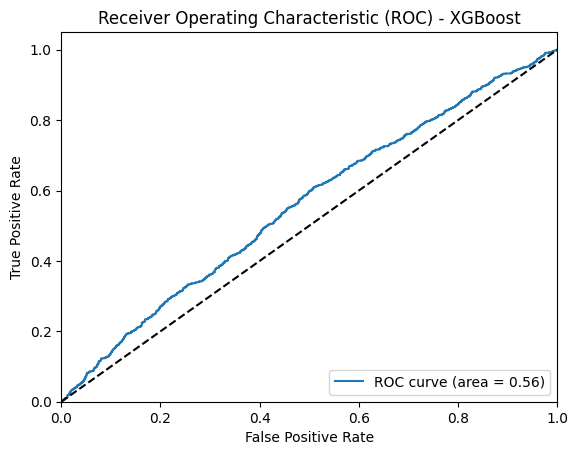

In [38]:
y_score_xgb = xgb_best.predict_proba(X_test)[:,1]
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_score_xgb)
roc_auc_xgb = auc(fpr_xgb, tpr_xgb)

plt.figure()
plt.plot(fpr_xgb, tpr_xgb, label='ROC curve (area = %0.2f)' % roc_auc_xgb)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) - XGBoost')
plt.legend(loc="lower right")
plt.show()

In [39]:
y_pred = grid_xgb.predict(X_test)
conf_mat = confusion_matrix(y_test, y_pred)
print(conf_mat)

[[867 513]
 [691 539]]


In [40]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.56      0.63      0.59      1380
           1       0.51      0.44      0.47      1230

    accuracy                           0.54      2610
   macro avg       0.53      0.53      0.53      2610
weighted avg       0.54      0.54      0.53      2610



In [41]:
import pickle

In [43]:
with open('../models/heroes_lr.pkl', 'wb') as f:
    pickle.dump(grid_logreg, f)

In [47]:
with open('../models/heroes_xgb.pkl', 'wb') as f:
    pickle.dump(grid_xgb, f)

In [48]:
grid_xgb.predict_proba(X_test)

array([[0.48164696, 0.51835304],
       [0.54578424, 0.45421574],
       [0.5918752 , 0.4081248 ],
       ...,
       [0.5452336 , 0.4547664 ],
       [0.45742548, 0.5425745 ],
       [0.5947131 , 0.40528694]], dtype=float32)

In [46]:
X_test

array([[2022,   12,   12, ...,    0,    0,    0],
       [2022,   11,   11, ...,    0,    0,    0],
       [2022,    8,   23, ...,    0,    0,    0],
       ...,
       [2022,   10,    9, ...,    0,    0,    0],
       [2022,   12,    1, ...,    0,    0,    0],
       [2022,    8,   12, ...,    0,    0,    0]], dtype=int64)